In [1]:
import pandas as pd
import pandasql as pq
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')
import nltk
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm
import tensorflow as tf
import torch
print('done')

done


# https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022

In [2]:
b = "\033[34m"
bl = "\033[0m"
r = "\033[31m"
rd = "\033[0m"
p = "\033[35m"
pl = "\033[0m"
g = "\033[32m"
gn = "\033[0m"
o = "\033[33m"
og = "\033[0m"

In [3]:
#reading data
df = pd.read_csv(r"C:\Users\Admin\Downloads\archive (4)\reviews.csv")

In [4]:
print(p+ 'shape of the data :' +pl,df.shape)
print(b+'columns :'+bl,df.columns)
df.head()

shape of the data : (61594, 5)
columns : Index(['Time_submitted', 'Review', 'Rating', 'Total_thumbsup', 'Reply'], dtype='object')


,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [5]:
# NA values on rating and review
print(df['Rating'].isna().sum())
print(df['Review'].isna().sum())

0
0


In [6]:
#some info about data
print ( "About ", (df['Reply'].count() / df['Rating'].count()*100).round(2), "% of Reviews got  replied ")
unique = ((df['Reply'].nunique() / df['Reply'].count() )*100).round(2)
print( unique , '% of total replies is unique and about ', 100 - unique, '%  is repeated')
df.describe(include='all')

About  0.35 % of Reviews got  replied 
83.33 % of total replies is unique and about  16.67 %  is repeated


,Time_submitted,Review,Rating,Total_thumbsup,Reply
count,61594,61594,61594.000000,61594.000000,216
unique,61300,61356,NaN,NaN,180
top,2022-03-08 18:49:19,Too many ads,NaN,NaN,"Hey, sorry to hear that. If you haven't tried ..."
freq,4,36,NaN,NaN,7
mean,NaN,NaN,3.155989,7.649381,NaN
std,NaN,NaN,1.673285,89.323143,NaN
min,NaN,NaN,1.000000,0.000000,NaN
25%,NaN,NaN,1.000000,0.000000,NaN
50%,NaN,NaN,3.000000,0.000000,NaN
75%,NaN,NaN,5.000000,1.000000,NaN


In [7]:
#taking only 1000 sample because it will take long time on cpu for roberta model (it would be a lot faster on gpu!) 
#remove this cell if you want to use the whole data 
#df = df.sample(1000)
#df.reset_index(inplace=True)
#df.shape

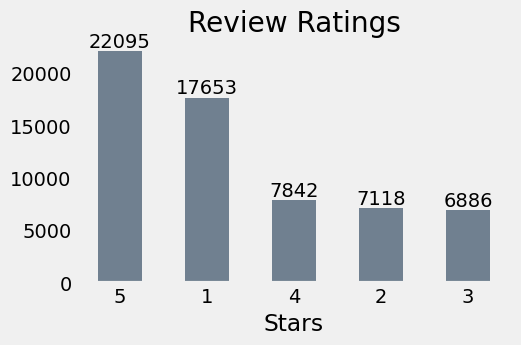

In [8]:
ax = df['Rating'].value_counts().plot(kind = 'bar', figsize=(5,3),color='slategrey')
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
ax.set_title('Review Ratings')
ax.set_xlabel('Stars')
ax.tick_params(axis='x', rotation=0)
ax.grid(False)
plt.show()

# NLTK

In [9]:
test = df['Review'][6]
test

"I love the selection and the lyrics are provided with the song you're listening to!"

In [10]:
tokens = nltk.word_tokenize(test)
pos = nltk.pos_tag(tokens)
chunk = nltk.chunk.ne_chunk(pos)
chunk.pprint()
# DT   determiner
# MD   modal (could, will)
# RB   adverb (occasionally, swiftly)
# PRP$ possessive pronoun (her, his, mine, my, our )...https://www.guru99.com/pos-tagging-chunking-nltk.html.

(S
  I/PRP
  love/VBP
  the/DT
  selection/NN
  and/CC
  the/DT
  lyrics/NNS
  are/VBP
  provided/VBN
  with/IN
  the/DT
  song/NN
  you/PRP
  're/VBP
  listening/VBG
  to/TO
  !/.)


# Vader seniment scoring
### It provides a compound score (-1 to 1) that represents the overall sentiment of text, as well as positive, neutral, and negative scores (0 to 1) indicating the intensity of each sentiment.

In [11]:
#Positive example

from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
text = "I love using NLTK for natural language processing."
scores = analyzer.polarity_scores(text)
compound_score = scores['compound']
positive_score = scores['pos']
neutral_score = scores['neu']
negative_score = scores['neg']
print("Compound Score: ", compound_score)
print("Positive Score: ", positive_score)
print("Neutral Score: ", neutral_score)
print("Negative Score: ", negative_score)


Compound Score:  0.7717
Positive Score:  0.573
Neutral Score:  0.427
Negative Score:  0.0


In [12]:
#Negative example
text_n = "I hate you NLTK"
score = analyzer.polarity_scores(text_n)
compound_score_2 = score['compound']
positive_score_2 = score['pos']
neutral_score_2 = score['neu']
negative_score_2 = score['neg']
print("Compound Score: ", compound_score_2)
print("Positive Score: ", positive_score_2)
print("Neutral Score: ", neutral_score_2)
print("Negative Score: ", negative_score_2)

Compound Score:  -0.5719
Positive Score:  0.0
Neutral Score:  0.351
Negative Score:  0.649


In [13]:
#trying on our sample
analyzer.polarity_scores(test)

{'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'compound': 0.6696}

In [14]:
#adding id column
df['ID'] = range(1, len(df) + 1)

In [15]:
#running polarity score on the entire data

results = {}
for ix, pol in df.iterrows():
    text = pol['Review']
    iden = pol['ID']  # Convert index to tuple
    results[iden] = analyzer.polarity_scores(text)

In [58]:
# joining the scores with the original data: 
scores_data = pd.DataFrame(results).T
scores_data  = scores_data.reset_index().rename(columns={'index':'ID'})
scores_data = scores_data.merge(df, how ='left')

In [59]:
scores_data.head()

,ID,neg,neu,pos,compound,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,1,0.000,0.564,0.436,0.9211,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2,0.243,0.353,0.404,0.6249,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,3,0.107,0.635,0.258,0.5859,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,4,0.296,0.704,0.000,-0.5209,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,5,0.000,0.740,0.260,0.7149,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


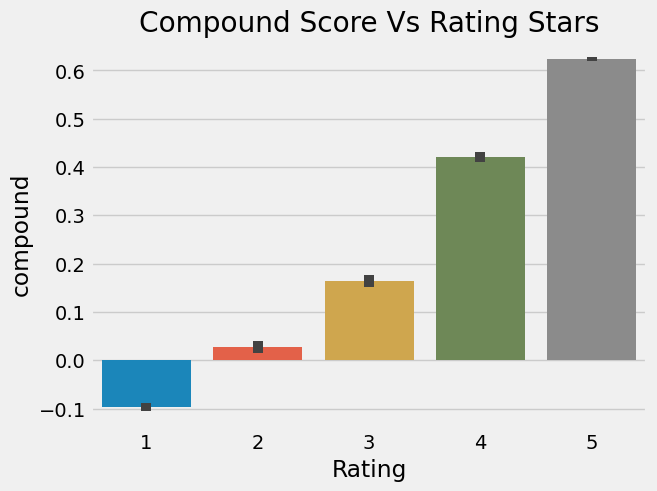

In [18]:
ax = sns.barplot(data = scores_data , x = "Rating" , y = "compound")
ax.set_title("Compound Score Vs Rating Stars")
plt.show()

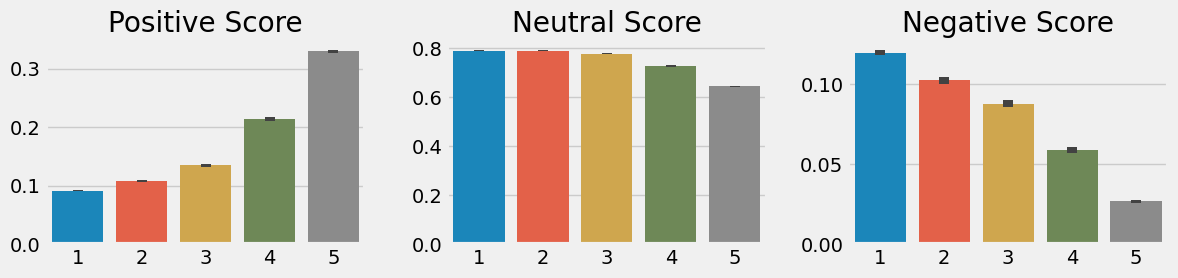

In [19]:
fig, axs = plt.subplots(1,3, figsize = (12,3))
sns.barplot(data = scores_data , x = "Rating" , y = "pos" ,ax = axs[0])
sns.barplot(data = scores_data , x = "Rating" , y = "neu" ,ax = axs[1])
sns.barplot(data = scores_data , x = "Rating" , y = "neg" ,ax = axs[2])

axs[0].set_title("Positive Score")
axs[1].set_title("Neutral Score")
axs[2].set_title("Negative Score")

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
plt.show()

# Roberta pretrained model

In [20]:
Model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(Model)
model = AutoModelForSequenceClassification.from_pretrained(Model)

In [21]:
encoded = tokenizer(test, return_tensors='pt')
test_res = model(**encoded)
test_score = test_res[0][0].detach().numpy()
test_score  = softmax(test_score)

In [22]:
#vader vs roberta in our test review
print(p+" 1- Vader model scores for the example :\n" + pl,g+test+gn)
vader = analyzer.polarity_scores(test)
v_list = list(vader.items())
print(v_list[0])
print(v_list[1])
print(v_list[2])
scores_ro = {
    'roberta_neg':test_score[0],
    'roberta_neu':test_score[1],
    'roberta_pos':test_score[2]}
print(b+"\n 2- Roberta model scores for the example : \n"+ bl , g+test+gn)
scores_ro

 1- Vader model scores for the example :
 I love the selection and the lyrics are provided with the song you're listening to!
('neg', 0.0)
('neu', 0.743)
('pos', 0.257)

 2- Roberta model scores for the example : 
 I love the selection and the lyrics are provided with the song you're listening to!


{'roberta_neg': 0.0018604372,
 'roberta_neu': 0.0129699735,
 'roberta_pos': 0.98516965}

In [23]:
def roberta_score(test):
    encoded = tokenizer(test, return_tensors='pt')#pt-pytorch
    test_res = model(**encoded)
    test_score = test_res[0][0].detach().numpy()
    test_score  = softmax(test_score)
    roberta_score = {
    'roberta_neg':test_score[0],
    'roberta_neu':test_score[1],
    'roberta_pos':test_score[2]}
    return roberta_score

In [24]:
#Gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
def roberta_score_gpu(test):
    encoded = tokenizer(test, return_tensors='pt').to(device)
    test_res = model(**encoded)
    test_score = test_res[0][0].detach().cpu().numpy()
    test_score = softmax(test_score)
    roberta_score = {
        'roberta_neg': test_score[0],
        'roberta_neu': test_score[1],
        'roberta_pos': test_score[2]
    }
    return roberta_score

results_roberta = {}
for i, roberta in tqdm(df.iterrows(), total=len(df)):
    try:
        text = roberta['Review']
        iden = roberta['ID']
        results_roberta[iden] = roberta_score_gpu(text)
    except RuntimeError:
        print(f"broke for {i}")


  0%|          | 0/61594 [00:00<?, ?it/s]

broke for 4722
broke for 20091
broke for 23287
broke for 40566
broke for 43922


In [25]:
# #Cpu version
# def roberta_score_cpu(test):
#     encoded = tokenizer(test, return_tensors='pt')
#     test_res = model(**encoded)
#     test_score = test_res[0][0].detach().numpy()
#     test_score = softmax(test_score)
#     roberta_score = {
#         'roberta_neg': test_score[0],
#         'roberta_neu': test_score[1],
#         'roberta_pos': test_score[2]
#     }
#     return roberta_score

# results_roberta = {}
# for i, roberta in tqdm(df.iterrows(), total=len(df)):
#     try:
#         text = roberta['Review']
#         iden = roberta['ID']
#         results_roberta[iden] = roberta_score_cpu(text)
#     except RuntimeError:
#         print(f"broke for {i}")

Using a GPU (specifically a GTX1050ti) to process data took approximately 18 minutes, which is much faster than the 45 minutes it took to process 1000 samples using a CPU. The advice is to use a GPU for faster processing. Only five reviews were not successful due to the limitation in the length of the reviews.

In [60]:
scores_roberta = pd.DataFrame(results_roberta).T
scores_roberta = scores_roberta.reset_index().rename(columns={'index':'ID'})
scores_roberta = scores_roberta.merge(scores_data, how ='left')

In [61]:
#scores_roberta.drop(['compound'], axis = 1,inplace=True)
scores_roberta.rename(columns = {'neg':'Vader_neg', 'neu':'Vader_neu', 'pos':'Vader_pos','compound':'vader_compound'},inplace=True)

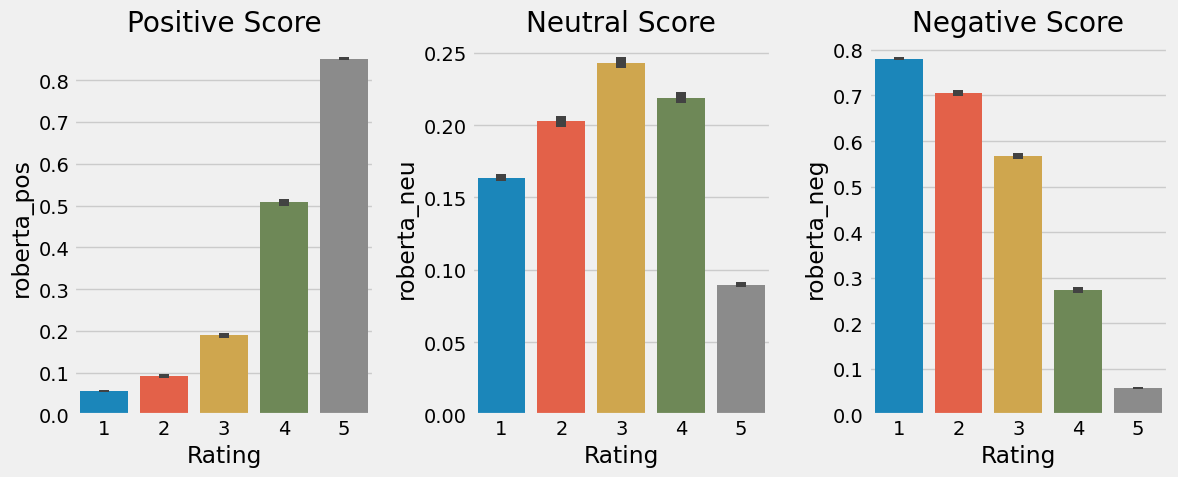

In [28]:
fig, axs = plt.subplots(1,3, figsize = (12,5))
sns.barplot(data = scores_roberta , x = "Rating" , y = "roberta_pos" ,ax = axs[0])
sns.barplot(data = scores_roberta , x = "Rating" , y = "roberta_neu" ,ax = axs[1])
sns.barplot(data = scores_roberta , x = "Rating" , y = "roberta_neg" ,ax = axs[2])
axs[0].set_title("Positive Score")
axs[1].set_title("Neutral Score")
axs[2].set_title("Negative Score")
plt.tight_layout()
plt.show()

# comparing bettween vader and roberta scores

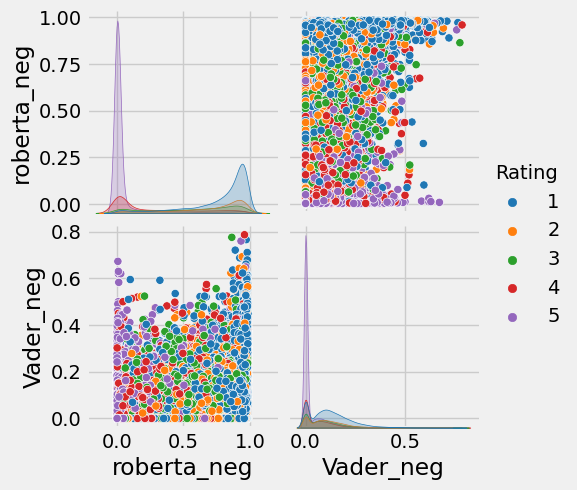

In [29]:
plot = "Select roberta_neg,roberta_neu,roberta_pos,Vader_neg,\
Vader_neu,Vader_pos,Rating from scores_roberta "

plot_one = pq.sqldf(plot,locals())
sns.pairplot(data=plot_one,vars=['roberta_neg','Vader_neg',],\
hue='Rating',palette='tab10')

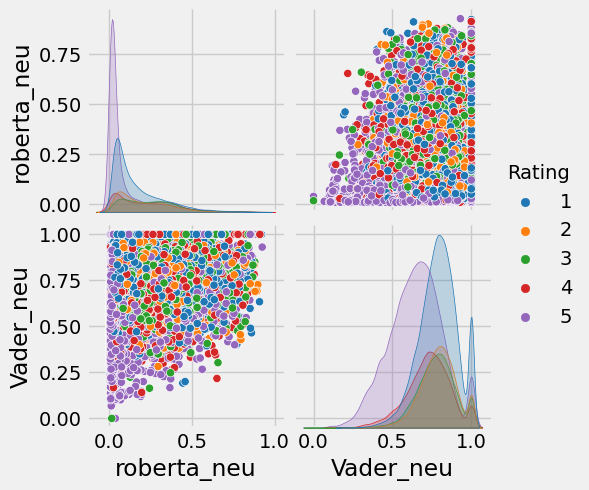

In [30]:
sns.pairplot(data=plot_one,vars=['roberta_neu','Vader_neu',],\
hue='Rating',palette='tab10')


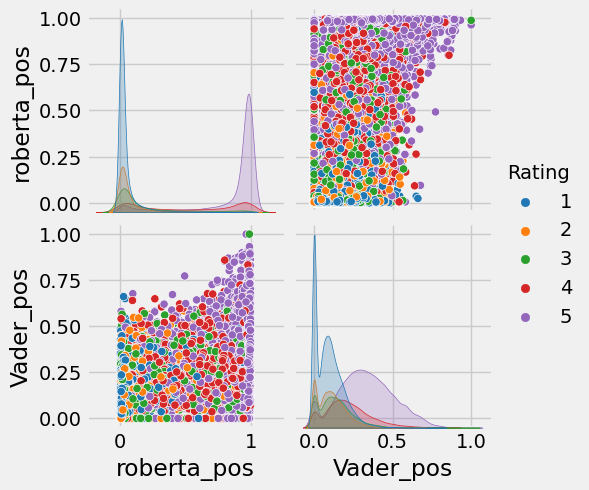

In [53]:
sns.pairplot(data=plot_one,vars=['roberta_pos','Vader_pos',],\
hue='Rating',palette='tab10')

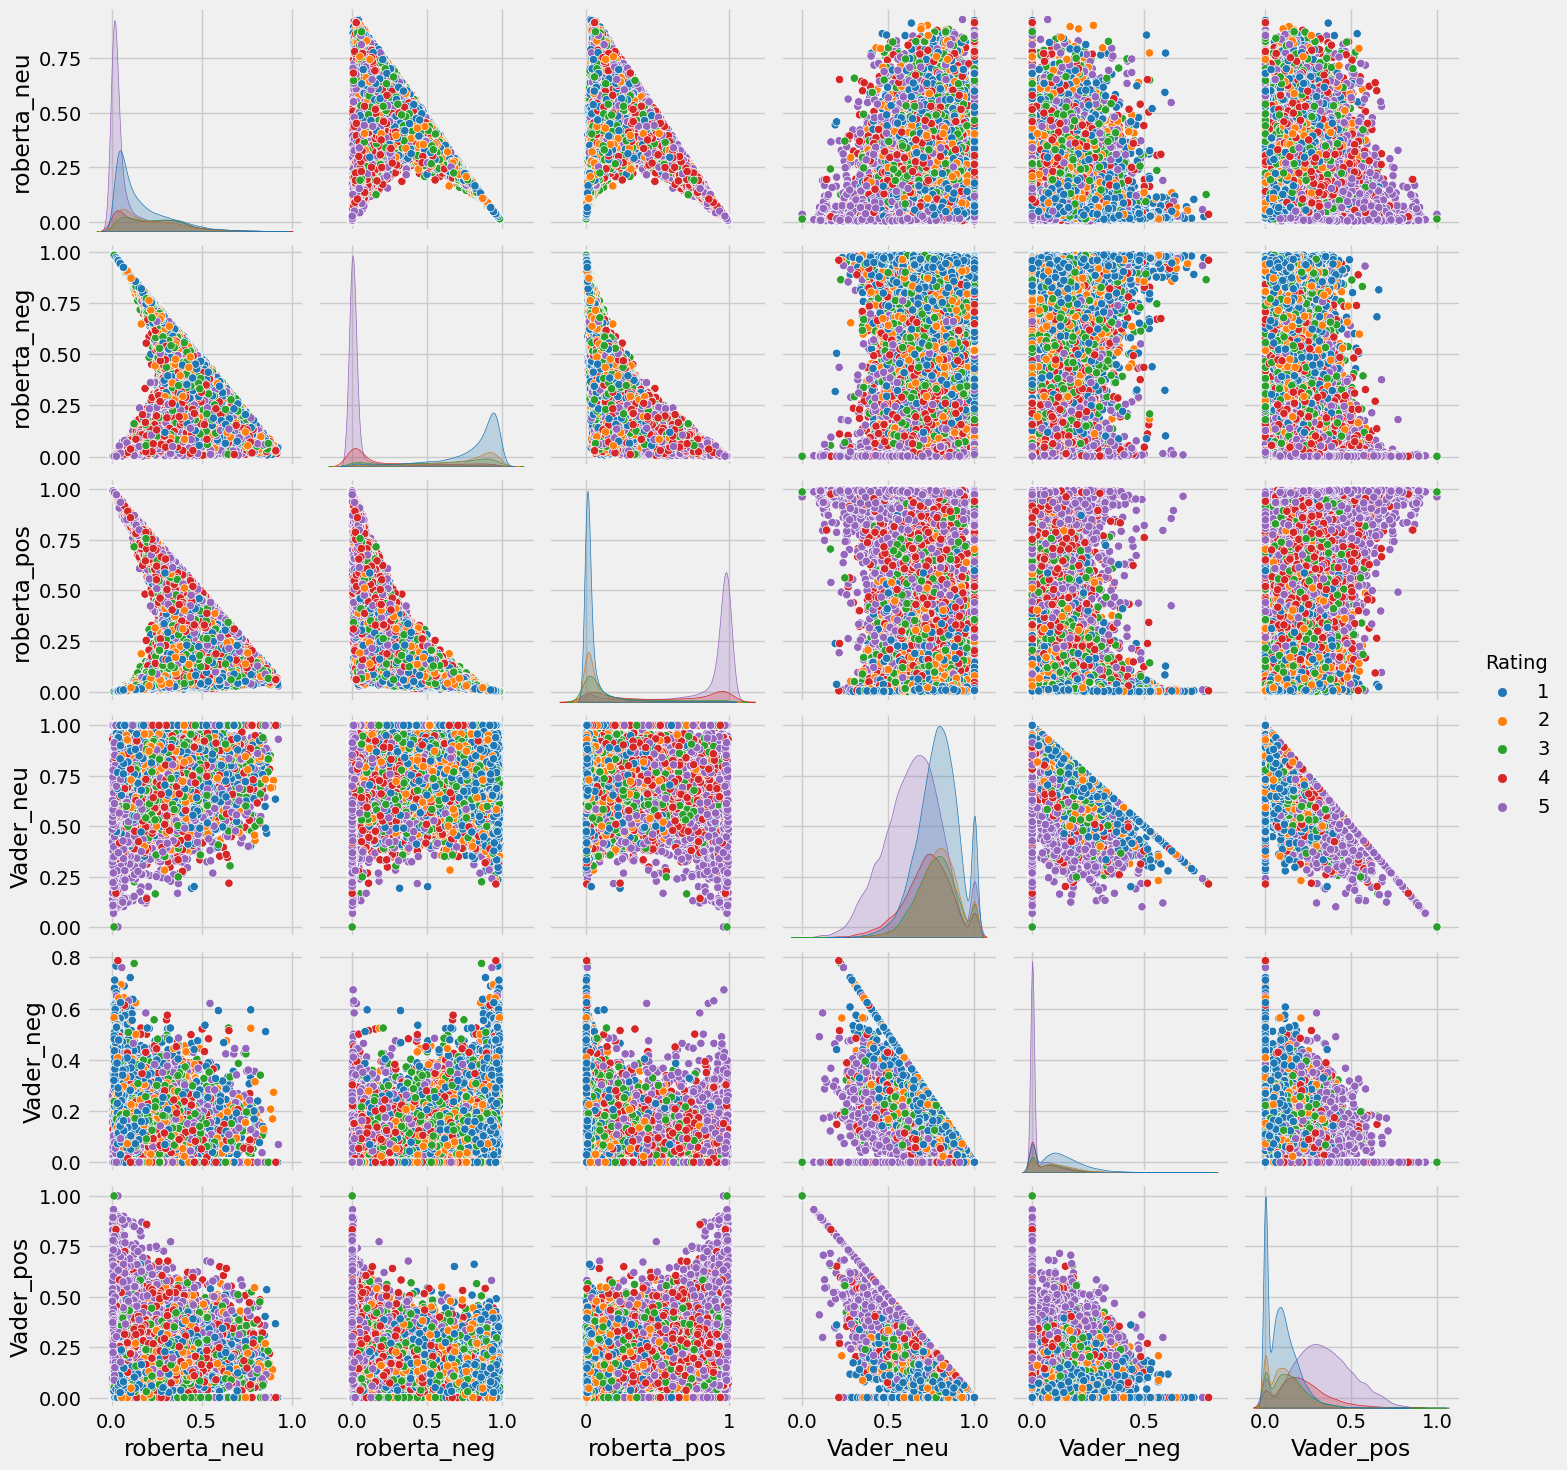

In [56]:
sns.pairplot(data=plot_one,vars=['roberta_neu','roberta_neg','roberta_pos','Vader_neu','Vader_neg','Vader_pos'],\
hue='Rating',palette='tab10')

# Testing

## Vader

In [33]:
#negative reviews VS rating (5 stars)

Vader_neg = "Select Review, Vader_neg,Rating from scores_roberta where Rating = 5 \
order by Vader_neg desc limit(5) "
Test_Vader_neg = pq.sqldf(Vader_neg,locals())

### When examining the most negative reviews in relation to the highest possible rating (5 stars),the Vader model does not always perform well. For instance, the review in the second position appears to have a positive or neutral sentiment rather than a negative one. Similarly, the review in the last position also seems more positive than negative.

In [34]:
Test_Vader_neg

,Review,Vader_neg,Rating
0,Non stop adds.ITS STUPID,0.760,5
1,I can't help but love Spotify,0.673,5
2,Hate the ads,0.649,5
3,Hate the ads,0.649,5
4,"No complaints, all good,finding songs I'd forg...",0.630,5


In [35]:
Vader_pos = "Select Review, Vader_pos,Rating from scores_roberta where Rating = 1 \
order by Vader_pos desc limit(5) "
Test_Vader_pos = pq.sqldf(Vader_pos,locals())

### There are also some problems when comparing the lowest possible rating to the highest positivity score provided by the Vader model. For instance, the third statement, Super slow interface. ,appears  to convey a negative sentiment rather than a positive one, while the fourth statement,Please turn off shuffle play!!!,  can be considered slightly negative.

In [36]:
Test_Vader_pos

,Review,Vader_pos,Rating
0,Awesome love using Spotify,0.806,1
1,Very nice i love spotify,0.791,1
2,Super slow interface.,0.661,1
3,Please turn off shuffle play!!!,0.650,1
4,"Like music, must have,very good 👍",0.643,1


In [37]:
#selecting the highest negativity rate for the highiest rating (5 stars):
Roberta_pos = "Select Review, roberta_neg,Rating from scores_roberta where Rating = 5 \
order by roberta_neg desc limit(5) "
Test_Roberta_pos = pq.sqldf(Roberta_pos,locals())
pd.set_option('display.max_colwidth', None)

### Despite receiving the highest possible rating of 5 stars, all of the reviews below express negative sentiment.

In [38]:
Test_Roberta_pos

,Review,roberta_neg,Rating
0,"Guys literally, do you want to delete your app or what?. TOO MUCH ADS. 3 - 4 ads in a row, do you even know how much disturbing and disgusting it is. Ruins the mood completely.",0.981631,5
1,I honestly hate it. It plays random songs and I cannot listen to what I want BECAUSE I DON'T HAVE PREMIUM. You are all too greedy. Uninstalled,0.980609,5
2,The app is misbehaving It is not opening Showing something went wrong Very bad experience this time Disappointed!,0.979988,5
3,"Very disappointed with this app. Idk why it's logging me out again and again. Also everytime I open it, it shows no internet connection even though I'm connected.",0.979140,5
4,The new update is really terrible. It lags at the slightest opening of the app.,0.978693,5


In [39]:
#lowest Ratting(stars) VS roberta highest scores for positivity
Roberta_pos = "Select Review, roberta_pos,Rating from scores_roberta where Rating = 1 \
order by roberta_pos desc limit(5) "
Test_pos = pq.sqldf(Roberta_pos,locals())

### In spite of the low rating of 1 star, every review below contains positive sentiment.

In [40]:
Test_pos

,Review,roberta_pos,Rating
0,This is my the most favorite music app I love it thanks Spotify for the best music's Thank you 😊,0.993472,1
1,I love Spotify. You can listen to any music(song) you want!!! I love it ❤️❤️❤️🎶✨,0.992988,1
2,It's a good app to have because they play good music 🎶 and different types of songs that people can dance to and sing to 😊 love Spotify music 🎶 enjoy ☺️ Spotify music 🎵🎶 w,0.992364,1
3,I really enjoy all the music played in Spotify . I love old songs with my favorite singers. Thank you Spotify i'm greatfull to hear my favorite songs,0.992284,1
4,Good 👍 morning everything looks great on music 🎶 I think it would be great 👍,0.992061,1


#### The code below is used to summarize the sentiment scores of a dataset based on the Roberta scores. A new column is created called 'Sentiment', which captures the overall sentiment of each row of data based on the highest value among the Roberta scores. For example, if the positive score is higher than both the negative and neutral scores, then the overall sentiment will be classified as 'Positive' in the new column. ( This method of sentiment classification based on the highest Roberta score is not the most ideal approach, but it is being implemented for the sake of simplicity in this particular project. )

## ROBERTA

In [41]:
df_sql = "Select *,CASE\
           WHEN roberta_pos > roberta_neg AND roberta_pos > roberta_neu THEN 'Positive'\
           WHEN roberta_neg > roberta_pos AND roberta_neg > roberta_neu THEN 'Negative'\
           WHEN roberta_neu > roberta_pos AND roberta_neu > roberta_neg THEN 'Neutral'\
           ELSE 'unknown'\
           END AS Sentiment\
           FROM scores_roberta;"

Results_df = pq.sqldf(df_sql,locals())
Results_df['Sentiment'].value_counts()

Sentiment
Negative    30175
Positive    26495
Neutral      4919
Name: count, dtype: int64

<Axes: xlabel='Sentiment'>

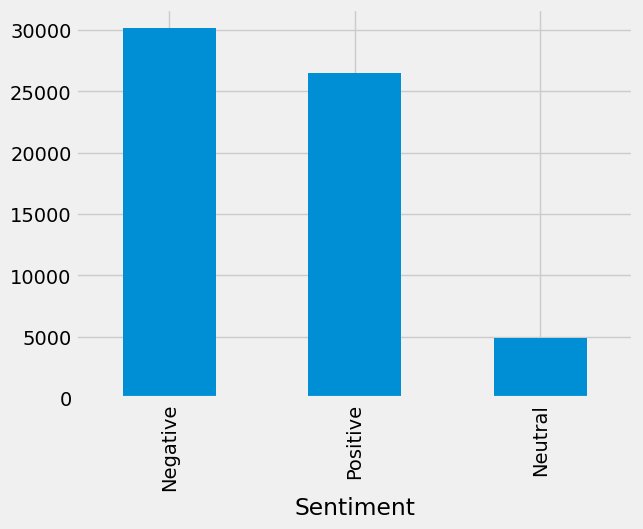

In [42]:
Results_df['Sentiment'].value_counts().plot(kind="bar")

In [43]:
idea = "Select avg(roberta_neg) AVG_NEG ,avg(roberta_neu)AVG_NEU,avg(roberta_pos)AVG_POS,\
Sentiment,Rating,count(Sentiment) as Total from Results_df GROUP BY Rating ,Sentiment ORDER BY 6 DESC "
Results_idea = pq.sqldf(idea,locals())
Results_idea

,AVG_NEG,AVG_NEU,AVG_POS,Sentiment,Rating,Total
0,0.011546,0.057921,0.930533,Positive,5,19850
1,0.844650,0.131331,0.024019,Negative,1,15837
2,0.801259,0.162234,0.036507,Negative,2,5956
3,0.752717,0.196570,0.050713,Negative,3,4718
4,0.047541,0.135844,0.816615,Positive,4,4350
5,0.690518,0.234713,0.074770,Negative,4,2420
6,0.708518,0.223343,0.068138,Negative,5,1244
7,0.084742,0.209927,0.705331,Positive,3,1240
8,0.283083,0.543358,0.173558,Neutral,1,1237
9,0.243105,0.521025,0.235870,Neutral,4,1072


In [44]:
#sample
pd.reset_option('display.max_colwidth')
sample = Results_df.sample(100)
sample[['roberta_neg', 'roberta_neu', 'roberta_pos','Sentiment']]

,roberta_neg,roberta_neu,roberta_pos,Sentiment
9102,0.354364,0.612263,0.033372,Neutral
49559,0.083349,0.701214,0.215437,Neutral
6825,0.002404,0.006785,0.990811,Positive
25711,0.944891,0.049573,0.005536,Negative
35142,0.738955,0.223700,0.037345,Negative
...,...,...,...,...
27168,0.814929,0.158065,0.027006,Negative
51908,0.003013,0.038329,0.958658,Positive
30837,0.064802,0.096389,0.838809,Positive
24985,0.909009,0.078065,0.012926,Negative


# VADER

In [45]:
df_sql_VADER = "Select *,CASE\
           WHEN Vader_pos > Vader_neg AND Vader_pos > Vader_neu THEN 'Positive'\
           WHEN Vader_neg> Vader_pos AND Vader_neg > Vader_neu THEN 'Negative'\
           WHEN Vader_neu > Vader_pos AND Vader_neu > Vader_neg THEN 'Neutral'\
           ELSE 'unknown'\
           END AS Sentiment\
           FROM scores_roberta;"
Results_df_VADER = pq.sqldf(df_sql_VADER,locals())
Results_df_VADER['Sentiment'].value_counts()

Sentiment
Neutral     56881
Positive     4433
Negative      193
unknown        82
Name: count, dtype: int64

In [46]:
unknown = "Select Vader_neg,Vader_neu,Vader_pos,Sentiment FROM Results_df_VADER WHERE Sentiment LIKE 'unknown'"
pq.sqldf(unknown,locals())

# It can be difficult to determine how to sort values that are similar, such as when there are 
# equal values for different sentiment scores like 0.5 for both neutral and positive or 0.35 
# for both negative and neutral. This suggests that the VADER model may not be confident in 
# assigning a clear score for those cases.

,Vader_neg,Vader_neu,Vader_pos,Sentiment
0,0.000,0.500,0.500,unknown
1,0.000,0.500,0.500,unknown
2,0.000,0.500,0.500,unknown
3,0.000,0.500,0.500,unknown
4,0.351,0.297,0.351,unknown
...,...,...,...,...
77,0.000,0.500,0.500,unknown
78,0.000,0.500,0.500,unknown
79,0.000,0.500,0.500,unknown
80,0.000,0.500,0.500,unknown


<Axes: xlabel='Sentiment'>

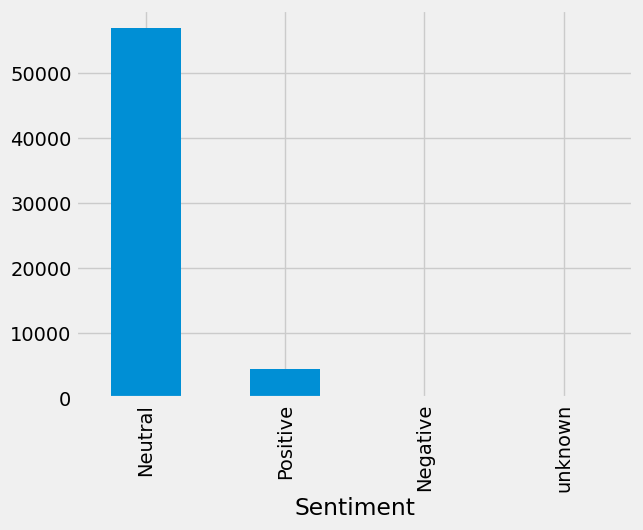

In [47]:
Results_df_VADER['Sentiment'].value_counts().plot(kind='bar')

In [48]:
idea_v = "Select avg(Vader_neg) AVG_NEG ,avg(Vader_neu)AVG_NEU,avg(Vader_pos)AVG_POS,\
Sentiment,Rating,count(Sentiment) as Total from Results_df_VADER GROUP BY Rating ,Sentiment ORDER BY 6 DESC "
Results_idea_v = pq.sqldf(idea_v,locals())
Results_idea_v

,AVG_NEG,AVG_NEU,AVG_POS,Sentiment,Rating,Total
0,0.029718,0.698831,0.271449,Neutral,5,18040
1,0.117420,0.792023,0.090557,Neutral,1,17498
2,0.059935,0.743634,0.196430,Neutral,4,7447
3,0.101577,0.791386,0.107038,Neutral,2,7083
4,0.087227,0.781031,0.131745,Neutral,3,6813
5,0.009601,0.397772,0.592630,Positive,5,3960
6,0.017994,0.405868,0.576143,Positive,4,363
7,0.541434,0.408425,0.050123,Negative,1,106
8,0.026638,0.492259,0.481121,unknown,5,58
9,0.043500,0.404731,0.551769,Positive,3,52


##### ''can also be done by counting the compound score for roberta as follows : 

In [50]:
compound_roberta = "Select *,(roberta_pos - roberta_neg) * (1 - roberta_neu) compound_roberta FROM scores_roberta;"
compound_roberta_r = pq.sqldf(compound_roberta,locals())

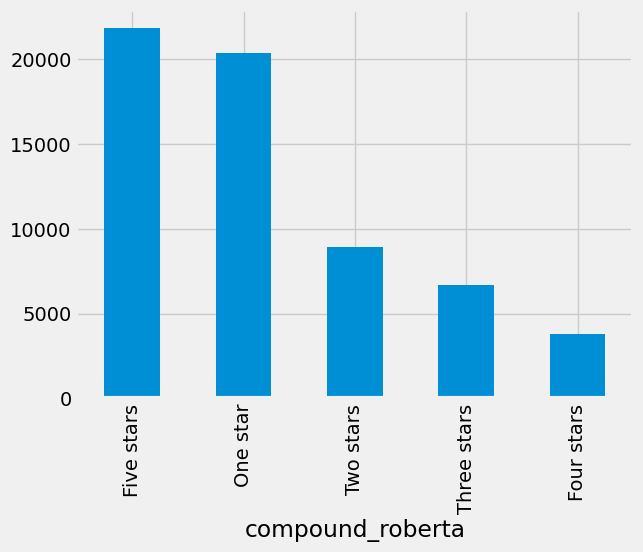

In [108]:
bins_roberta = pd.cut(compound_roberta_r['compound_roberta'], bins=5,labels=['One star', 'Two stars', 'Three stars', 'Four stars', 'Five stars'])                  
bin_counts = pd.value_counts(bins)
bin_counts.plot(kind='bar')
compound_roberta_r['bins_roberta'] = bins_roberta

<Axes: xlabel='vader_compound'>

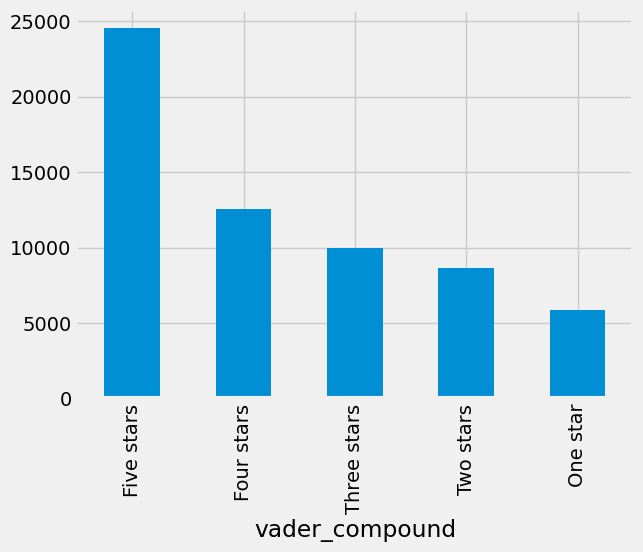

In [82]:
#making some kiind of rating like stars based on bins out of the compund values of roberta and vader
bins_vader = pd.cut(scores_roberta['vader_compound'], bins=5,labels=['One star', 'Two stars', 'Three stars', 'Four stars', 'Five stars'])
bins_vader_counts = pd.value_counts(bins_vader)
bins_vader_counts.plot(kind='bar')
scores_roberta['bins_vader'] = bins_vader

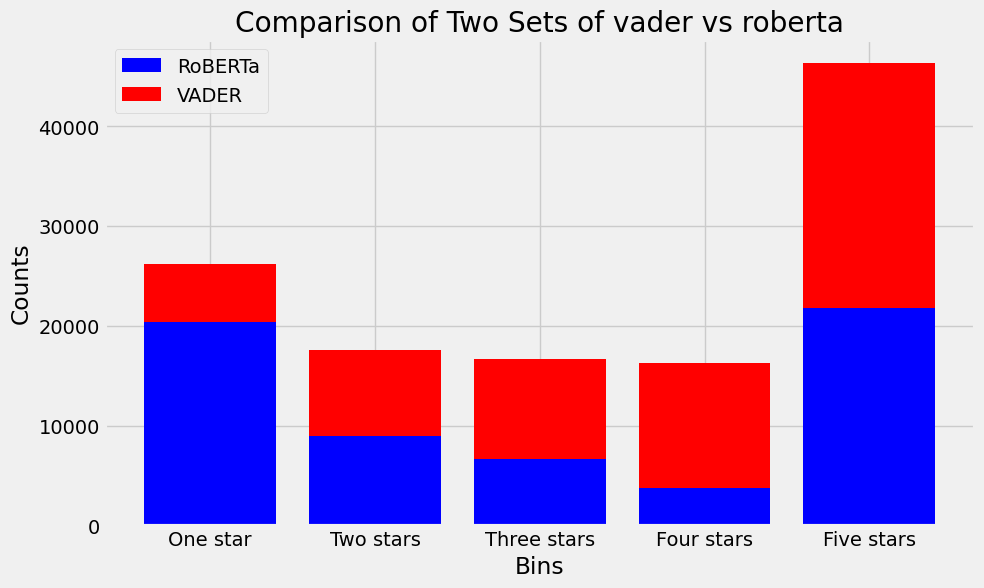

In [125]:
roberta_counts = compound_roberta_r.groupby('bins_roberta')['compound_roberta'].count()
vader_counts = scores_roberta.groupby('bins_vader')['vader_compound'].count()

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(roberta_counts.index.astype(str), roberta_counts.values, color='b')
bar2 = ax.bar(vader_counts.index.astype(str), vader_counts.values, bottom=roberta_counts.values, color='r')
ax.set_xlabel('Bins')
ax.set_ylabel('Counts')
ax.set_title('Comparison of Two Sets of vader vs roberta')
ax.legend((bar1[0], bar2[0]), ('RoBERTa', 'VADER'))
plt.show()